In [1]:
class SubmissionBase:

    submit_url = 'https://www-origin.coursera.org/api/' \
                 'onDemandProgrammingImmediateFormSubmissions.v1'
    save_file = 'token.pkl'

    def __init__(self, assignment_slug, part_names):
        self.assignment_slug = assignment_slug
        self.part_names = part_names
        self.login = None
        self.token = None
        self.functions = OrderedDict()
        self.args = dict()

    def grade(self):
        print('\nSubmitting Solutions | Programming Exercise %s\n' % self.assignment_slug)
        self.login_prompt()

        # Evaluate the different parts of exercise
        parts = OrderedDict()
        for part_id, result in self:
            parts[str(part_id)] = {'output': sprintf('%0.5f ', result)}
        result, response = self.request(parts)
        response = json.loads(response.decode("utf-8"))

        # if an error was returned, print it and stop
        if 'errorMessage' in response:
            print(response['errorMessage'])
            return

        # Print the grading table
        print('%43s | %9s | %-s' % ('Part Name', 'Score', 'Feedback'))
        print('%43s | %9s | %-s' % ('---------', '-----', '--------'))
        for part in parts:
            part_feedback = response['partFeedbacks'][part]
            part_evaluation = response['partEvaluations'][part]
            score = '%d / %3d' % (part_evaluation['score'], part_evaluation['maxScore'])
            print('%43s | %9s | %-s' % (self.part_names[int(part) - 1], score, part_feedback))
        evaluation = response['evaluation']
        total_score = '%d / %d' % (evaluation['score'], evaluation['maxScore'])
        print('                                  --------------------------------')
        print('%43s | %9s | %-s\n' % (' ', total_score, ' '))

    def login_prompt(self):
        if os.path.isfile(self.save_file):
            with open(self.save_file, 'rb') as f:
                login, token = pickle.load(f)
            reenter = input('Use token from last successful submission (%s)? (Y/n): ' % login)

            if reenter == '' or reenter[0] == 'Y' or reenter[0] == 'y':
                self.login, self.token = login, token
                return
            else:
                os.remove(self.save_file)

        self.login = input('Login (email address): ')
        self.token = input('Token: ')

        # Save the entered credentials
        if not os.path.isfile(self.save_file):
            with open(self.save_file, 'wb') as f:
                pickle.dump((self.login, self.token), f)

    def request(self, parts):
        params = {
            'assignmentSlug': self.assignment_slug,
            'secret': self.token,
            'parts': parts,
            'submitterEmail': self.login}

        params = urlencode({'jsonBody': json.dumps(params)}).encode("utf-8")
        f = urlopen(self.submit_url, params)
        try:
            return 0, f.read()
        finally:
            f.close()

    def __iter__(self):
        for part_id in self.functions:
            yield part_id

    def __setitem__(self, key, value):
        self.functions[key] = value


def sprintf(fmt, arg):
    """ Emulates (part of) Octave sprintf function. """
    if isinstance(arg, tuple):
        # for multiple return values, only use the first one
        arg = arg[0]

    if isinstance(arg, (np.ndarray, list)):
        # concatenates all elements, column by column
        return ' '.join(fmt % e for e in np.asarray(arg).ravel('F'))
    else:
        return fmt % arg
from urllib.parse import urlencode
from urllib.request import urlopen
import pickle
import json
from collections import OrderedDict
import numpy as np
import os
import sys
import numpy as np
from matplotlib import pyplot

sys.path.append('..')


def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))


class Grader(SubmissionBase):
    # Random Test Cases
    X = np.stack([np.ones(20),
                  np.exp(1) * np.sin(np.arange(1, 21)),
                  np.exp(0.5) * np.cos(np.arange(1, 21))], axis=1)

    y = (np.sin(X[:, 0] + X[:, 1]) > 0).astype(float)

    Xm = np.array([[-1, -1],
                   [-1, -2],
                   [-2, -1],
                   [-2, -2],
                   [1, 1],
                   [1, 2],
                   [2, 1],
                   [2, 2],
                   [-1, 1],
                   [-1, 2],
                   [-2, 1],
                   [-2, 2],
                   [1, -1],
                   [1, -2],
                   [-2, -1],
                   [-2, -2]])
    ym = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

    t1 = np.sin(np.reshape(np.arange(1, 25, 2), (4, 3), order='F'))
    t2 = np.cos(np.reshape(np.arange(1, 41, 2), (4, 5), order='F'))

    def __init__(self):
        part_names = ['Regularized Logistic Regression',
                      'One-vs-All Classifier Training',
                      'One-vs-All Classifier Prediction',
                      'Neural Network Prediction Function']

        super().__init__('multi-class-classification-and-neural-networks', part_names)

    def __iter__(self):
        for part_id in range(1, 5):
            try:
                func = self.functions[part_id]

                # Each part has different expected arguments/different function
                if part_id == 1:
                    res = func(np.array([0.25, 0.5, -0.5]), self.X, self.y, 0.1)
                    res = np.hstack(res).tolist()
                elif part_id == 2:
                    res = func(self.Xm, self.ym, 4, 0.1)
                elif part_id == 3:
                    res = func(self.t1, self.Xm) + 1
                elif part_id == 4:
                    res = func(self.t1, self.t2, self.Xm) + 1
                else:
                    raise KeyError
                yield part_id, res
            except KeyError:
                yield part_id, 0


# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline



In [2]:

# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()
# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size

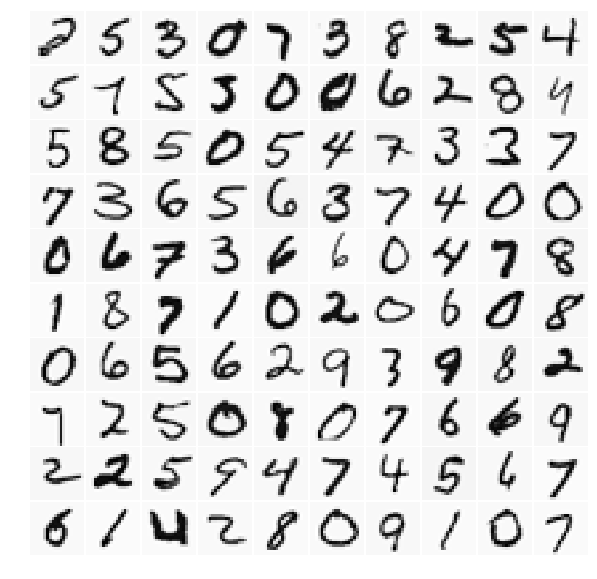

In [3]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [4]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)
print(theta_t)
# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

#creates a 5 x 1 array with values 1 for each aij.
#np.arange(1,16) creates a 1 x 15 array counting from 1 -> 16, regaranged to make a 5 x 3

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3
print(X_t)
print(y_t)

def sigmoid(z):
    # convert input to a numpy array
        z = np.array(z)
    
    # You need to return the following variables correctly 
        g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================
        g = 1/(1+np.exp(-z))

    # =============================================================
        return g

[-2. -1.  1.  2.]
[[ 1.   0.1  0.6  1.1]
 [ 1.   0.2  0.7  1.2]
 [ 1.   0.3  0.8  1.3]
 [ 1.   0.4  0.9  1.4]
 [ 1.   0.5  1.   1.5]]
[1 0 1 0 1]


In [7]:
def lrCostFunction(theta, X, y, lambda_):
  
    #Initialize some useful values
    m = y.size
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    theta = np.array(theta)
    
    #When doing regularization, we turn theta[0] = 0 AFTER dotting it
    
    # ====================== YOUR CODE HERE ======================

    h = sigmoid(X.dot(theta))
    #Since theta[0] is a bias (dot product of X*theta reveals that 1*theta[0] for all x sub 0)
    temp = theta
    temp[0] = 0
    print(h.shape)
    print(h)
    print(y)
    RHS = (lambda_/(2*m))*np.sum(pow(temp,2))
    J = ((1/(m))*np.sum( -y.dot(np.log(h))-(1-y).dot(np.log(1-h)) )) + RHS
    grad = (1/m)*((h-y).dot(X)) + ((lambda_/(m))*temp)
    
    # =============================================================
    return J, grad

In [8]:

J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

(5,)
[ 0.66818777  0.7109495   0.75026011  0.78583498  0.81757448]
[1 0 1 0 1]
Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


In [26]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. Note that we 
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    
    Instructions
    ------------
    You should complete the following code to train `num_labels`
    logistic regression classifiers with regularization parameter `lambda_`. 
    
    Hint
    ----
    You can use y == c to obtain a vector of 1's and 0's that tell you
    whether the ground truth is true/false for this class.
    
    Note
    ----
    For this assignment, we recommend using `scipy.optimize.minimize(method='CG')`
    to optimize the cost function. It is okay to use a for-loop 
    (`for c in range(num_labels):`) to loop over the different classes.
    
    Example Code
    ------------
    
        # Set Initial theta
        initial_theta = np.zeros(n + 1)
      
        # Set options for minimize
        options = {'maxiter': 50}
    
        # Run minimize to obtain the optimal theta. This function will 
        # return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options) 
    """
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    
    #For every number of labels,
    #return all_theta[c] = minimum of x.
    
    #each row represents a specific class. 
    #all_theta[c] creates the thetas that will minimimize the 
    #all_theta[c]
    
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='CG',
                                options=options) 
        all_theta[c] = res.x
        #For all labels, all_theta[c], it prints out the minimum of X.
    # ============================================================
    return all_theta

In [27]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)


In [9]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned logistic
    regression parameters (one-vs-all). You should set p to a vector of predictions
    (from 0 to num_labels-1).
    
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index 
    of the max for each row.
    """
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    
    p = np.argmax(sigmoid(X.dot(all_theta.T)),axis = 1)
    # ============================================================
    return p

In [10]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.18%


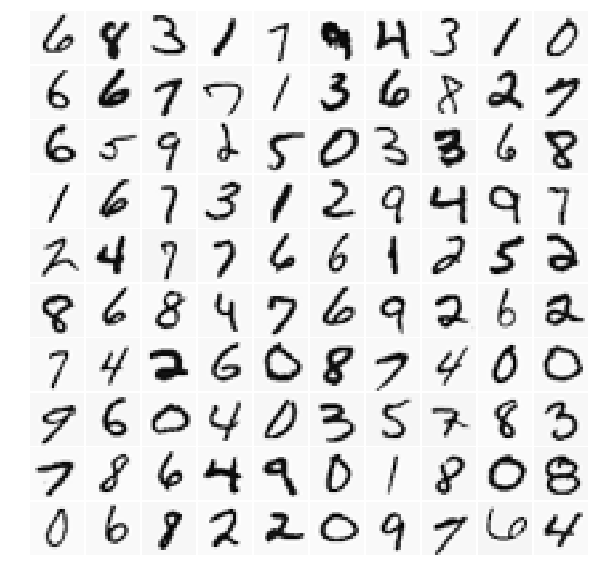

In [11]:

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [12]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('Data', 'ex3weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)
print(X[1,:].size)

400


In [13]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    
    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    
    Theta2: array_like
        Weights for the second layer in the neural network. 
        It has shape (output layer size x 2nd hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned neural
    network. You should set p to a vector containing labels 
    between 0 to (num_labels-1).

    
    """
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]
   
    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])
    # ====================== YOUR CODE HERE ======================
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a = np.array([[1,1,1],
           [0,0,0],
        [.5,.5,.5]])
    b = np.array([[2,2,2],
         [4,4,4],
        ])
    
    a1 = sigmoid(X.dot(Theta1.T))
    
    ones = np.array([np.ones(X[:,1].size)])
    ones = ones.T
    a1 = np.concatenate((ones,a1),axis = 1)

    a2 = sigmoid(a1.dot(Theta2.T))
    p = np.argmax(a2,axis = 1)
    
    return p

In [14]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


Neural Network Prediction: 9


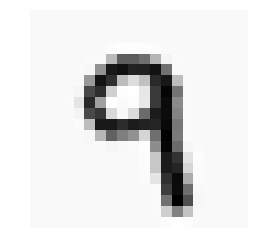

In [15]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

In [16]:
a = np.array([[2,4],
    [1,3],
    [7,1]])
print(np.argmax(a,axis = 1))

[1 1 0]


In [17]:
print(X.shape)

(5000, 400)


In [20]:
print(X)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
